# Introduction
This notebook shows the study of the [CWRU Bearing Dataset](https://csegroups.case.edu/bearingdatacenter/home), which contains data of normal and fault bearings. Artificial defects of different diameters (0.007 ~ 0.028 Inches) are manufactured at different locations of the bearings: inner raceway(IR), outer raceway(OR) and ball(B) defects. 

Experiments were conducted using a 2 hp Reliance Electri motor. Vibration data was recorded for motor loads of 0 to 3 hp (motor speed of 1797 to 1720 RPM) using accelerometers at the drive end (DE) and fan end (FE) and the data is stored as Matlab files. The sampling rate is 12 kHz and each Matlab file contains between ~120k to ~240k sample points. For more information please refer to the [website](https://csegroups.case.edu/bearingdatacenter/home).

This study focuses on the classification of the drive end bearing defects using only the signal data at **DE**. It is a **multiclass classification** problem. The input is the vibration signal data at DE and the output is the type of defects, i.e. **Normal, IR, OR, B**.


# Import and Define Helper Functions

In [1]:
# Data science libraries
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch.nn.modules.loss import CrossEntropyLoss

# Others
from IPython.core.debugger import set_trace
from pathlib import Path

from helper import *
from train_helper import *
import nn_model
from one_cycle import OneCycle, update_lr, update_mom

In [2]:
working_dir = Path()
save_model_path = working_dir / 'Model'
normal_path = working_dir / 'Data' / 'Normal'
DE_path = working_dir / 'Data' / '12k_DE'

# Train Test Split

In [3]:
df_all = get_df_all(normal_path, DE_path, segment_length=500, normalize=True)
features = df_all.columns[2:]
target = 'label'

In [9]:
df_all.shape

(17987, 502)

In [20]:
df_train_val = df_all[(df_all["filename"] != "OR021@6_3.mat") & 
                      (df_all["filename"] != "Normal_1.mat")]
df_test = df_all[(df_all["filename"] == "OR021@6_3.mat") | 
                 (df_all["filename"] == "Normal_1.mat")]

In [21]:
df_train_val["filename"].unique()

array(['Normal_0.mat', 'Normal_2.mat', 'Normal_3.mat', 'B007_0.mat',
       'B007_1.mat', 'B007_2.mat', 'B007_3.mat', 'B014_0.mat',
       'B014_1.mat', 'B014_2.mat', 'B014_3.mat', 'B021_0.mat',
       'B021_1.mat', 'B021_2.mat', 'B021_3.mat', 'B028_0.mat',
       'B028_1.mat', 'B028_2.mat', 'B028_3.mat', 'IR007_0.mat',
       'IR007_1.mat', 'IR007_2.mat', 'IR007_3.mat', 'IR014_0.mat',
       'IR014_1.mat', 'IR014_2.mat', 'IR014_3.mat', 'IR021_0.mat',
       'IR021_1.mat', 'IR021_2.mat', 'IR021_3.mat', 'IR028_0.mat',
       'IR028_1.mat', 'IR028_2.mat', 'IR028_3.mat', 'OR007@12_0.mat',
       'OR007@12_1.mat', 'OR007@12_2.mat', 'OR007@12_3.mat',
       'OR007@3_0.mat', 'OR007@3_1.mat', 'OR007@3_2.mat', 'OR007@3_3.mat',
       'OR007@6_0.mat', 'OR007@6_1.mat', 'OR007@6_2.mat', 'OR007@6_3.mat',
       'OR014@6_0.mat', 'OR014@6_1.mat', 'OR014@6_2.mat', 'OR014@6_3.mat',
       'OR021@12_0.mat', 'OR021@12_1.mat', 'OR021@12_2.mat',
       'OR021@12_3.mat', 'OR021@3_0.mat', 'OR021@3_1.mat',
 

In [23]:
df_test["filename"].unique()

array(['Normal_1.mat', 'OR021@6_3.mat'], dtype=object)

In [25]:
print(df_train_val.shape, df_test.shape)

(16777, 502) (1210, 502)


In [6]:
# subsample_size = len(df_all) // 10
# subsample_idx = np.random.permutation(len(df_all))[:subsample_size]
# df_all = df_all.iloc[subsample_idx]

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train_val[features], 
                                                      df_train_val[target], 
                                                      test_size=0.20, random_state=42, shuffle=True
                                                     )

In [27]:
bs = 64

In [28]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_valid = torch.tensor(X_valid.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_valid = torch.tensor(y_valid.values, dtype=torch.long)

train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)
train_dl, valid_dl = get_dataloader(train_ds, valid_ds, bs)

In [33]:
X_test = torch.tensor(df_test[features].values, dtype=torch.float32)
y_test = torch.tensor(df_test[target].values, dtype=torch.long)

test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs * 2)

# Fit One Cycle

In [29]:
# Set hyperparameters
lr = 0.01
# bs = 64
wd = 1e-5
epochs = 15
loss_func = CrossEntropyLoss()
onecycle = OneCycle(int(len(X_train) * epochs / bs), lr, prcnt=10, div=25, momentum_vals=(0.95, 0.8))

In [30]:
%%time
# Instantiate model, optimizers and train
model = nn_model.CNN_1D_2L(len(features))
# opt = optim.SGD(model.parameters(), lr=lr/10, momentum=0.95, weight_decay=wd)
opt = optim.Adam(model.parameters(), lr=lr/10, betas=(0.9, 0.999), weight_decay=wd)
model, metrics = fit(epochs, model, loss_func, opt, train_dl, valid_dl, one_cycle=onecycle, train_metric=True)

EPOCH 	 Train Loss 	 Val Loss 	 Train Acc 	 Val Acc 	
0 	 0.27863 	 0.29481 	 0.89621 	0.89035 	
1 	 0.38209 	 0.40847 	 0.83578 	0.83731 	
2 	 0.13392 	 0.12907 	 0.95321 	0.94994 	
3 	 0.12036 	 0.12549 	 0.95261 	0.94279 	
4 	 0.25232 	 0.25327 	 0.91685 	0.91508 	
5 	 0.12703 	 0.16458 	 0.94896 	0.94160 	
6 	 0.34902 	 0.37835 	 0.88801 	0.88468 	
7 	 0.03721 	 0.03845 	 0.98808 	0.98391 	
8 	 0.03011 	 0.04119 	 0.98785 	0.98153 	
9 	 0.01965 	 0.02060 	 0.99359 	0.99344 	
10 	 0.02165 	 0.02812 	 0.99277 	0.98808 	
11 	 0.01327 	 0.02042 	 0.99575 	0.99166 	
12 	 0.01645 	 0.02306 	 0.99501 	0.99046 	
13 	 0.02864 	 0.03481 	 0.98890 	0.98749 	
14 	 0.01708 	 0.02258 	 0.99426 	0.99046 	
Wall time: 20min 47s


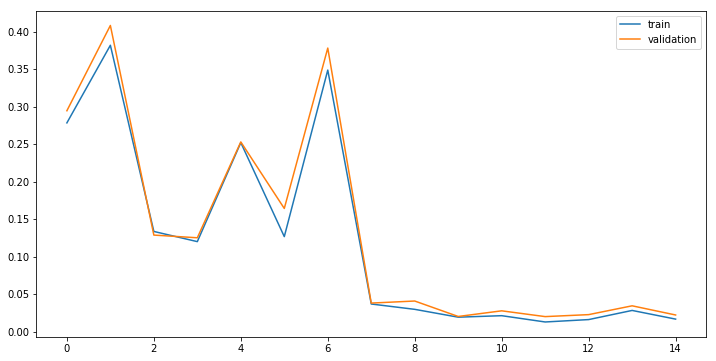

In [31]:
plt.figure(figsize=(12,6))
plt.plot(range(epochs), metrics["train_loss"], label='train')
plt.plot(range(epochs), metrics["val_loss"], label='validation')
plt.legend()

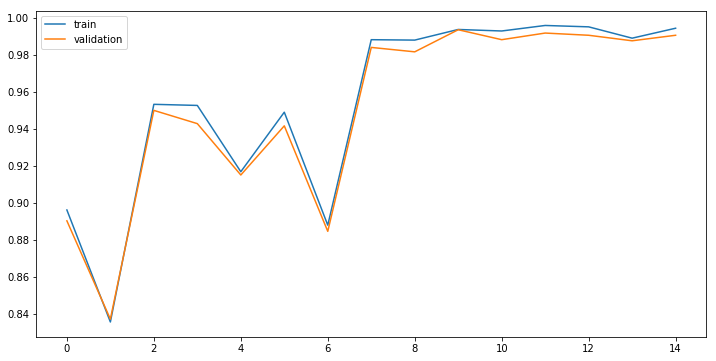

In [32]:
plt.figure(figsize=(12,6))
plt.plot(range(epochs), metrics["train_accuracy"], label='train')
plt.plot(range(epochs), metrics["val_accuracy"], label='validation')
plt.legend()

# Save trained model

In [14]:
torch.save(model.state_dict(), save_model_path / 'model.pth')

In [16]:
model2 = nn_model.CNN_1D_2L(len(features))

In [17]:
model2.load_state_dict(torch.load(save_model_path / 'model.pth'))
model2.eval()

CNN_1D_2L(
  (layer1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5)
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (linear1): Linear(in_features=16000, out_features=4, bias=True)
)

In [37]:
%%time
print(validate(model, test_dl, loss_func))

(8.118054079542981e-08, 1.0)
Wall time: 1.59 s
